## Load Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing.image import load_img,array_to_img,img_to_array
from tensorflow.keras.layers import Dense,Conv2D,Conv2DTranspose,BatchNormalization,LeakyReLU,Flatten,Dropout,Reshape

## Load Images

In [4]:
PATH = './cartoonset100k/cartoonset100k/'
cartoon_imgs = []
for img_dir in os.listdir(PATH):
    for img in os.listdir(PATH+'/'+img_dir):
        if img.endswith(".png"):
            cartoon_imgs.append(np.array(img_to_array(load_img(PATH+'/'+img_dir+'/'+img,target_size=(32,32)))))

## Image Details

In [6]:
cartoon_imgs = np.array(cartoon_imgs)

In [7]:
cartoon_imgs.shape

(100000, 32, 32, 3)

In [8]:
cartoon_imgs = cartoon_imgs/127.5 -1

In [9]:
cartoon_imgs.min(),cartoon_imgs.max()

(-1.0, 1.0)

## Plot Image

In [11]:
def plot_img(imgs,n_col=None):
    n_col = n_col or len(imgs)
    n_row = (len(imgs)-1) // (n_col -1)
    fig = plt.figure(figsize=(n_col,n_row))
    for i,img in enumerate(imgs):
        plt.subplot(n_row,n_col,i+1)
        img = (img+1)*127.5
        img = img.astype(np.uint16)
        plt.imshow(img)
        plt.axis('off')

In [12]:
id = np.random.randint(0,len(cartoon_imgs)-1,20)

In [13]:
id

array([16663, 99357, 51130, 31314, 92306,  5958, 44565, 66062, 24753,
       52517, 54035, 46255, 70985, 56823, 55093, 81857, 35311, 26401,
       25273, 96614])

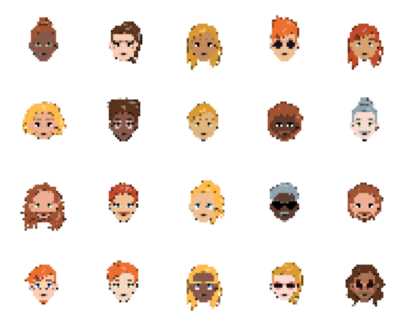

In [14]:
plot_img(cartoon_imgs[id],5)

In [15]:
NOISE = 100
BATCH = 8
BUFFER_SIZE=10000

## Build Generator

In [17]:
def build_gen(NOISE):
    i = Input(shape=([NOISE]))
    x = Dense(units=4*4*512,activation=LeakyReLU(alpha=0.2))(i)
    x = Reshape([4,4,512])(x)
    x = Conv2DTranspose(filters=256,kernel_size=3,strides=2,padding='same',activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(filters=128,kernel_size=3,strides=2,padding='same',activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(filters=64,kernel_size=3,strides=2,padding='same',activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(filters=3,kernel_size=3,padding='same',activation="tanh")(x)
    return Model(i,x)

In [18]:
g_model = build_gen(NOISE)

In [19]:
g_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        1179904   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      295040

## Test Generator Model

The Generated Img Shape is : (2, 32, 32, 3)


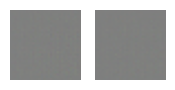

In [21]:
Data_Points = tf.random.normal([2,NOISE])
gen_imgs = g_model(Data_Points,training=False)
plot_img(gen_imgs.numpy(),2)
print(f'The Generated Img Shape is : {gen_imgs.shape}')

## Build Descriminator

In [23]:
def build_des():
    i = Input(shape=([32,32,3]))
    x = Conv2D(filters=256,strides=2,kernel_size=3,activation=LeakyReLU(alpha=0.2),padding="same")(i)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(filters=128,strides=2,kernel_size=3,activation=LeakyReLU(alpha=0.2),padding="same")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(filters=64,strides=2,kernel_size=3,activation=LeakyReLU(alpha=0.2),padding="same")(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(1,activation="sigmoid")(x)
    return Model(i,x)

In [24]:
d_model = build_des()

In [25]:
d_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       7168      
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 256)      1024      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         295040    
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                           

In [26]:
d_model(gen_imgs)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.49991086],
       [0.49961   ]], dtype=float32)>

## Loss & Optimizer For GAN

In [28]:
loss = tf.keras.losses.BinaryCrossentropy()

In [29]:
def gen_loss(fake_output):
    return loss(tf.ones_like(fake_output),fake_output)

In [30]:
def des_loss(fake_output,real_output):
    fake_label = tf.zeros_like(fake_output)
    real_label = tf.ones_like(real_output)
    real_loss = loss(real_label,real_output)
    fake_loss = loss(fake_label,fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [31]:
gen_opt = tf.keras.optimizers.Adam(1.5e-4, 0.5)
des_opt = tf.keras.optimizers.Adam(1.5e-4, 0.5)

## Training function

In [33]:
@tf.function
def train_step(images):
    Data = tf.random.normal([BATCH,NOISE])
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        gen_imgs = g_model(Data,training=True)
        
        real_output = d_model(images,training=True)
        fake_output = d_model(gen_imgs,training=True)
        
        d_loss = des_loss(fake_output,real_output)
        g_loss = gen_loss(fake_output)
        
        grad_of_gen = g_tape.gradient(g_loss,g_model.trainable_variables)
        grad_of_des = d_tape.gradient(d_loss,d_model.trainable_variables)
        
        gen_opt.apply_gradients(zip(grad_of_gen,g_model.trainable_variables))
        des_opt.apply_gradients(zip(grad_of_des,d_model.trainable_variables))
    return g_loss,d_loss

## Training

In [35]:
def train(dataset,epochs=3):
    for i in range(1,epochs+1):
        d_loss_list = []
        g_loss_list = []
        for img_batch in dataset:
            gloss,dloss = train_step(img_batch)
            g_loss_list.append(gloss)
            d_loss_list.append(dloss)
        avg_gloss = sum(g_loss_list)/len(g_loss_list)
        avg_dloss = sum(d_loss_list)/len(d_loss_list)
        print(f'Epoch : {i}  G_loss : {avg_gloss}, D_loss : {avg_dloss}')
        print("================================\n")

In [36]:
Dataset = tf.data.Dataset.from_tensor_slices(cartoon_imgs)
Dataset = Dataset.shuffle(BUFFER_SIZE).batch(BATCH,drop_remainder=True).prefetch(1)

In [37]:
train(Dataset,50)

Epoch : 1  G_loss : 4.894699573516846, D_loss : 0.2439168393611908

Epoch : 2  G_loss : 5.671812534332275, D_loss : 0.12031606584787369

Epoch : 3  G_loss : 7.316937446594238, D_loss : 0.04473135620355606

Epoch : 4  G_loss : 7.8969950675964355, D_loss : 0.03647004812955856

Epoch : 5  G_loss : 7.9933037757873535, D_loss : 0.0429946593940258

Epoch : 6  G_loss : 8.170658111572266, D_loss : 0.03686363622546196

Epoch : 7  G_loss : 8.526175498962402, D_loss : 0.03722590580582619

Epoch : 8  G_loss : 8.865388870239258, D_loss : 0.029084462672472

Epoch : 9  G_loss : 8.971670150756836, D_loss : 0.03069094941020012

Epoch : 10  G_loss : 9.965154647827148, D_loss : 0.02138618938624859

Epoch : 11  G_loss : 9.685576438903809, D_loss : 0.02310979552567005

Epoch : 12  G_loss : 10.298203468322754, D_loss : 0.019350994378328323

Epoch : 13  G_loss : 10.498512268066406, D_loss : 0.020669208839535713

Epoch : 14  G_loss : 10.323817253112793, D_loss : 0.018946358934044838

Epoch : 15  G_loss : 10.0

## Test

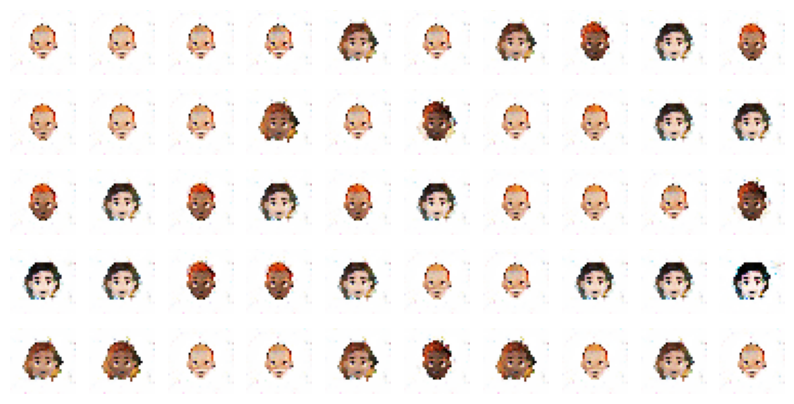

In [41]:
Data_Points = tf.random.normal([50,NOISE])
gen_imgs = g_model(Data_Points)
plot_img(gen_imgs.numpy(),10)